In [1]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Exploring the OOI ERDDAP server

### Learning objectives:

- Explorer an ERDDAP server with the python interface (erddapy);
- Find a glider for a time/region of interest;
- Download the data with a familiar format and create some plots.

In [2]:
from erddapy import ERDDAP


server = ("https://erddap-uncabled.oceanobservatories.org/"
          "uncabled/erddap")
e = ERDDAP(server=server)

### What services are available in the **erddap-uncabled.oceanobservatories** server?

In [3]:
import pandas as pd


df = pd.read_csv(
    e.get_search_url(response='csv', search_for='all')
)

In [4]:
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)

We have 1000 tabledap, 0 griddap, and 0 wms endpoints.


### Let's query all the datasets that have the "trajectory" CDM data type.

In [5]:
url = e.get_categorize_url(
    categorize_by="cdm_data_type",
    value="trajectory",
    response="csv",
)

df = pd.read_csv(url)
dataset_ids = df.loc[~df['tabledap'].isnull(), 'Dataset ID'].tolist()

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} datasets")

Found 544 datasets


### We don't really want all that! Let us get all the deployments that have *salinity* data within a lon/lat/time extent.

In [6]:
kw = {
    "min_time": "2017-01-05T00:00:00Z",
    "min_time": "2019-06-12T00:00:00Z",
    "min_lon": -136,
    "max_lon": -120,
    "min_lat": 41.78,
    "max_lat": 52.24,
    "standard_name": "sea_water_practical_salinity",
    "cdm_data_type": "trajectory",
}

In [7]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
dataset_ids = search["Dataset ID"].values

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} Datasets:\n{dataset_ids_list}")

Found 1 Datasets:
CE05MOAS-GL384-05-CTDGVM000-ctdgv_m_glider_instrument-telemetered-deployment0006-tabledap


In [8]:
e.dataset_id = dataset_ids[0]
e.protocol = "tabledap"

e.variables = [
    "sci_water_pressure_dbar",
    "latitude",
    "longitude",
    "practical_salinity",
    "sci_water_temp",
    "time",
]

url = e.get_download_url()
print(url)

https://erddap-uncabled.oceanobservatories.org/uncabled/erddap/tabledap/CE05MOAS-GL384-05-CTDGVM000-ctdgv_m_glider_instrument-telemetered-deployment0006-tabledap.html?sci_water_pressure_dbar,latitude,longitude,practical_salinity,sci_water_temp,time


In [9]:
import pandas as pd


df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

df.head()

,sci_water_pressure_dbar (dbar),latitude (degrees_north),longitude (degrees_east),practical_salinity (1),sci_water_temp (\u00baC)
time (UTC),,,,,
2019-05-03 23:31:59+00:00,9.240000,44.628238,-124.306597,32.048113,10.6932
2019-05-03 23:33:00+00:00,18.860000,44.627991,-124.307012,32.187151,10.3812
2019-05-03 23:34:00+00:00,28.310001,44.627746,-124.307424,32.454599,9.7831
2019-05-03 23:35:01+00:00,37.010000,44.627499,-124.307840,32.512662,9.4914
2019-05-03 23:36:01+00:00,44.230000,44.627253,-124.308253,32.601386,9.3329


Exercise: experiment with the `e.to_xarray()` method. Why/where use one or the other?

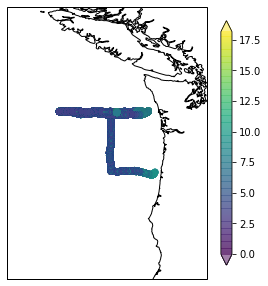

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

dx, dy = 2, 4
x = df["longitude (degrees_east)"]
y = df["latitude (degrees_north)"]

fig, ax = plt.subplots(figsize=(5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
cs = ax.scatter(x, y, c=df[r"sci_water_temp (\u00baC)"],
                s=50, alpha=0.5, edgecolor='none')
cbar = fig.colorbar(cs, orientation='vertical',
                    fraction=0.1, shrink=0.9, extend='both')
ax.coastlines('10m')
ax.set_extent([x.min()-dx, x.max()+dx, y.min()-dy, y.max()+dy]);

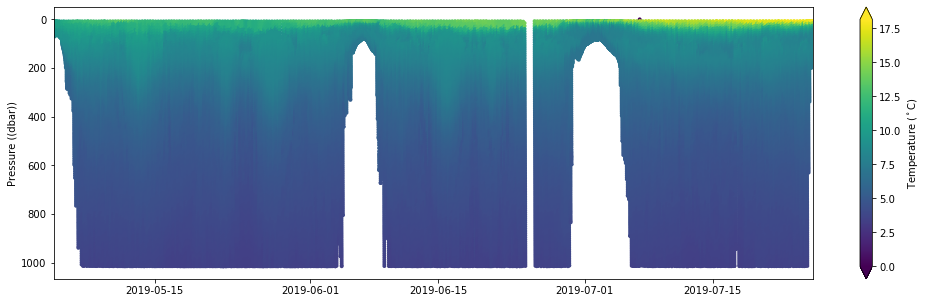

In [11]:
# import matplotlib.dates as mdates
    
fig, ax = plt.subplots(figsize=(17, 5))
cs = ax.scatter(df.index, df["sci_water_pressure_dbar (dbar)"],
                s=15, c=df[r"sci_water_temp (\u00baC)"],
                marker="o", edgecolor="none",)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
# xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
# ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_ylabel("Pressure ((dbar))");

### Exercise: enable the commented out code above and check how you can customize the time time marks.

In [12]:
import gsw
import numpy as np

s = np.linspace(0, 42, 100)
t = np.linspace(-2, 40, 100)

s, t = np.meshgrid(s, t)

sigma = gsw.sigma0(s, t)

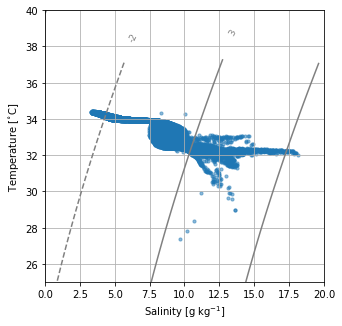

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

cnt = np.arange(-7, 35, 5)
cs = ax.contour(s, t, sigma, colors='gray', levels=cnt)
ax.clabel(cs, fontsize=9, inline=1, fmt='%2i')

ax.set_xlabel('Salinity [g kg$^{-1}$]')
ax.set_ylabel('Temperature [$^{\circ}$C]')
ax.scatter(df[r"sci_water_temp (\u00baC)"],
           df["practical_salinity (1)"],
           s=10, alpha=0.5)

ax.grid(True)
ax.axis([0, 20, 25, 40]);

Exercise: explore the web interface for the server and find a dataset of interested, download a format that you are familiar with and plot it (using the web interface or the Python, your choice).

<https://erddap-uncabled.oceanobservatories.org/uncabled/erddap>

Bonus points: replicate the same query we had here using the web-interface.